In [1]:
import os
import numpy as np
from PIL import Image
from scipy.spatial import distance
import random
import matplotlib.pyplot as plt
from matplotlib import cm

In [2]:
# 전역 변수 설정
IMAGE_HEIGHT = 112
IMAGE_WIDTH = 92
FACE_COUNT = 10  # 사람 수
MAX_EIGENFACES = 50  # 생성할 총 eigenface 수

In [3]:
def load_raw_image(filepath):
    # 파일을 바이너리 모드로 열기
    with open(filepath, "rb") as fid:
        # numpy의 fromfile을 사용하여 uint8로 읽기
        face_image = np.fromfile(fid, dtype='uint8')
        # 이미지 크기에 맞게 reshape (112 x 92)
        face_image = np.reshape(face_image, [IMAGE_HEIGHT, IMAGE_WIDTH])
    return face_image

In [4]:
def load_dataset(data_dir):
    images = []
    labels = []
    filenames = []
    
    # 디렉토리 내의 모든 .raw 파일 찾기
    for filename in sorted(os.listdir(data_dir)):
        if filename.endswith('.raw'):
            person_id = int(filename.split('-')[0]) - 1
            
            # 이미지 로드
            img_path = os.path.join(data_dir, filename)
            img = load_raw_image(img_path)
            
            # 이미지, 라벨, 파일명 저장
            images.append(img.flatten())  # 1차원 벡터로 변환
            labels.append(person_id)
            filenames.append(filename)
    
    return np.array(images), np.array(labels), filenames

In [5]:
# 평균 얼굴 반환
def compute_mean_face(faces):
    return np.mean(faces, axis=0)

In [6]:
# PCA를 사용하여 eigenfaces 계산      
def compute_eigenfaces(faces, mean_face, num_components=MAX_EIGENFACES):
    # 평균 얼굴을 뺀 차이 행렬
    diff_matrix = faces - mean_face
    
    # 공분산 행렬 계산 X * X^T
    cov_matrix = np.dot(diff_matrix, diff_matrix.T)
    
    # eigenvalues와 eigenvectors 계산
    eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
    
    # 큰 eigenvalue 순으로 정렬 
    # eigenvalue가 크면 중요도가 높다는 뜻으로 이해함
    idx = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]
    
    # 원래 차원으로 변환
    eigenfaces = np.dot(diff_matrix.T, eigenvectors)
    
    # 정규화
    for i in range(eigenfaces.shape[1]):
        eigenfaces[:, i] = eigenfaces[:, i] / np.linalg.norm(eigenfaces[:, i])
    
    # 요청된 개수만큼만 반환
    return eigenfaces[:, :num_components]

In [7]:
# 얼굴을 eigenface 공간으로 투영
def project_face(face, mean_face, eigenfaces, num_components):
    diff = face - mean_face
    return np.dot(diff, eigenfaces[:, :num_components])

In [8]:
def reconstruct_face(weights, mean_face, eigenfaces):
    """
    eigenface 가중치로부터 얼굴 재구성
    """
    return mean_face + np.dot(weights, eigenfaces.T)

In [ ]:
# 테스트 얼굴의 ID 예측
def recognize_face(test_face, train_faces, train_labels, mean_face, eigenfaces, num_components):
    # 테스트 얼굴을 eigenface 공간으로 투영
    test_weights = project_face(test_face, mean_face, eigenfaces, num_components)
    
    # 모든 학습 얼굴에 대한 가중치 계산
    train_weights = np.array([project_face(face, mean_face, eigenfaces, num_components) 
                             for face in train_faces])
    
    # 유클리드 거리 계산
    min_dist = float('inf')
    min_idx = -1
    
    for i, train_weight in enumerate(train_weights):
        dist = distance.euclidean(test_weights, train_weight)
        if dist < min_dist:
            min_dist = dist
            min_idx = i
    
    # 가장 가까운 얼굴의 라벨 반환
    return train_labels[min_idx]

In [ ]:
# numpy 배열을 이미지로 저장
def save_image(img_array, filename, shape=(IMAGE_HEIGHT, IMAGE_WIDTH)):
    # 1차원 배열인 경우 2차원으로 reshape
    if len(img_array.shape) == 1:
        img_array = img_array.reshape(shape)
    
    # 픽셀 값 정규화 (0-255 범위로)
    img_array = ((img_array - img_array.min()) / (img_array.max() - img_array.min()) * 255).astype(np.uint8)
    
    # PIL 이미지로 변환하여 저장
    img = Image.fromarray(img_array)
    img.save(filename)

In [ ]:
# 얼굴 인식 정확도 평가
def evaluate_accuracy(train_faces, train_labels, test_faces, test_labels, mean_face, eigenfaces, num_components):
    correct = 0
    total = len(test_faces)
    
    for i, test_face in enumerate(test_faces):
        predicted_label = recognize_face(test_face, train_faces, train_labels, 
                                        mean_face, eigenfaces, num_components)
        if predicted_label == test_labels[i]:
            correct += 1
    
    accuracy = (correct / total) * 100
    return accuracy

In [12]:
# 학습용, 테스트용 분할
def split_data(faces, labels, train_ratio):
    # 각 사람별로 데이터 분할
    train_faces = []
    train_labels = []
    test_faces = []
    test_labels = []
    
    for person_id in range(FACE_COUNT):
        # 해당 사람의 얼굴 인덱스 찾기
        person_indices = np.where(labels == person_id)[0]
        
        # 학습용 데이터 수 계산
        num_train = int(len(person_indices) * train_ratio)
        
        # 무작위로 인덱스 섞기
        np.random.shuffle(person_indices)
        
        # 학습용과 테스트용으로 분할
        train_indices = person_indices[:num_train]
        test_indices = person_indices[num_train:]
        
        # 데이터 추가
        train_faces.extend(faces[train_indices])
        train_labels.extend(labels[train_indices])
        test_faces.extend(faces[test_indices])
        test_labels.extend(labels[test_indices])
    
    return np.array(train_faces), np.array(train_labels), np.array(test_faces), np.array(test_labels)


In [13]:
def visualize_meanface_and_eigenfaces(mean_face, eigenfaces, num_to_show=9, title_suffix="", save_path=None):
    """
    평균 얼굴과 여러 eigenface를 matplotlib으로 시각화
    """
    # 그리드 크기 설정
    fig = plt.figure(figsize=(12, 8))
    
    # 평균 얼굴 표시
    ax = fig.add_subplot(3, 4, 1)
    ax.imshow(mean_face.reshape(IMAGE_HEIGHT, IMAGE_WIDTH), cmap='gray')
    ax.set_title(f'Mean Face {title_suffix}')
    ax.axis('off')
    
    # eigenfaces 표시
    for i in range(min(num_to_show, eigenfaces.shape[1])):
        ax = fig.add_subplot(3, 4, i+2)
        eigenface = eigenfaces[:, i].reshape(IMAGE_HEIGHT, IMAGE_WIDTH)
        
        # eigenface는 음수 값을 가질 수 있으므로 적절히 표시
        ax.imshow(eigenface, cmap='viridis')
        ax.set_title(f'Eigenface {i+1}')
        ax.axis('off')
    
    plt.tight_layout()
    
    # 저장 경로가 지정되지 않았다면 기본 경로 사용
    if save_path is None:
        save_path = './results/eigenfaces_visualization.png'
    
    plt.savefig(save_path, dpi=300)
    plt.close()
    
    # 3D 시각화 (첫 번째 eigenface)
    if eigenfaces.shape[1] > 0:  # eigenface가 하나 이상 있는지 확인
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')
        
        # 3D 메쉬 그리드 생성
        x = np.arange(0, IMAGE_WIDTH)
        y = np.arange(0, IMAGE_HEIGHT)
        x, y = np.meshgrid(x, y)
        
        # 첫 번째 eigenface 데이터
        first_eigenface = eigenfaces[:, 0].reshape(IMAGE_HEIGHT, IMAGE_WIDTH)
        
        # 표면 플롯
        surf = ax.plot_surface(x, y, first_eigenface, cmap=cm.coolwarm, linewidth=0, antialiased=True)
        
        ax.set_title(f'3D Visualization of First Eigenface {title_suffix}')
        fig.colorbar(surf, shrink=0.5, aspect=5)
        
        # 저장 경로의 확장자 앞에 _3d 추가
        if save_path:
            save_path_3d = save_path.replace('.png', '_3d.png')
        else:
            save_path_3d = './results/eigenface_3d_visualization.png'
        
        plt.savefig(save_path_3d, dpi=300)
        plt.close()

In [29]:
def main():
    data_dir = "image_dataset"
    results_dir = "results"
    
    print("데이터셋")
    faces, labels, filenames = load_dataset(data_dir)
    
    # 정확도 테이블 생성을 위한 비율 및 eigenface 개수 설정
    ratios = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]  # 1:9부터 7:3까지
    eigenface_nums = [1, 3, 5, 7, 9]  # 테스트할 eigenface 개수
    
    # 결과 테이블
    results = np.zeros((len(eigenface_nums), len(ratios)))
    
    # 각 조합에 대해 정확도 측정
    for j, ratio in enumerate(ratios):
        print(f"\n학습/테스트 비율: {ratio:.1f}:{1-ratio:.1f}")
        
        # 데이터 분할
        train_faces, train_labels, test_faces, test_labels = split_data(faces, labels, ratio)
        
        # 학습 데이터만으로 평균 얼굴 계산
        mean_face = compute_mean_face(train_faces)
        
        # 평균 얼굴 저장 (각 비율별로)
        save_image(mean_face, os.path.join(results_dir, f"mean_face_ratio_{int(ratio*10)}_{int((1-ratio)*10)}.jpg"))
        
        # 학습 데이터만으로 Eigenfaces 계산
        eigenfaces = compute_eigenfaces(train_faces, mean_face, MAX_EIGENFACES)
        
        # Eigenfaces 저장 (각 비율별로 처음 5개만)
        for i in range(min(5, MAX_EIGENFACES)):
            save_image(
                eigenfaces[:, i], 
                os.path.join(results_dir, f"eigenface{i}_ratio_{int(ratio*10)}_{int((1-ratio)*10)}.jpg")
            )
        
        # 각 eigenface 개수에 대해 정확도 측정
        for i, num_components in enumerate(eigenface_nums):
            # 특정 비율과 eigenface 개수에 대한 정확도 평가
            accuracy = evaluate_accuracy(
                train_faces, train_labels, test_faces, test_labels,
                mean_face, eigenfaces, num_components
            )
            
            # 결과 저장
            results[i, j] = accuracy
            
            print(f"Euclidean Distance Accuracy for #eigen faces {num_components} = {accuracy} % ({ratio*10:.0f} : {(1-ratio)*10:.0f})")
        
        # 각 비율별로 평균 얼굴과 eigenfaces 시각화
        visualize_meanface_and_eigenfaces(
            mean_face, eigenfaces, 
            num_to_show=5, 
            title_suffix=f"(Train:Test = {int(ratio*10)}:{int((1-ratio)*10)})",
            save_path=os.path.join(results_dir, f"eigenfaces_viz_ratio_{int(ratio*10)}_{int((1-ratio)*10)}.png")
        )
    
    # 결과 테이블 출력
    print("\n결과 테이블:")
    print("\t1:9\t2:8\t3:7\t4:6\t5:5\t6:4\t7:3")
    print("#eigenfaces")
    for i, num_components in enumerate(eigenface_nums):
        result_line = f"{num_components}\t"
        for j in range(len(ratios)):
            result_line += f"{results[i, j]:.1f}%\t"
        print(result_line)
    
    # 정확도 결과를 그래프로 시각화
    print("정확도 결과 시각화 중...")
    plt.figure(figsize=(12, 8))
    
    # 각 eigenface 개수별 선 그래프
    for i, num_components in enumerate(eigenface_nums):
        plt.plot(
            [f"{int(r*10)}:{int((1-r)*10)}" for r in ratios], 
            results[i], 
            marker='o', 
            linewidth=2, 
            label=f'Eigenfaces: {num_components}'
        )
    
    plt.xlabel('train_faces:test_faces')
    plt.ylabel('accuracy (%)')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    plt.tight_layout()
    plt.show()
    plt.close()
    
    return results

데이터셋

학습/테스트 비율: 0.1:0.9
Euclidean Distance Accuracy for #eigen faces 1 = 15.555555555555555 % (1 : 9)
Euclidean Distance Accuracy for #eigen faces 3 = 58.88888888888889 % (1 : 9)
Euclidean Distance Accuracy for #eigen faces 5 = 81.11111111111111 % (1 : 9)
Euclidean Distance Accuracy for #eigen faces 7 = 83.33333333333334 % (1 : 9)
Euclidean Distance Accuracy for #eigen faces 9 = 84.44444444444444 % (1 : 9)

학습/테스트 비율: 0.2:0.8
Euclidean Distance Accuracy for #eigen faces 1 = 38.75 % (2 : 8)
Euclidean Distance Accuracy for #eigen faces 3 = 76.25 % (2 : 8)
Euclidean Distance Accuracy for #eigen faces 5 = 85.0 % (2 : 8)
Euclidean Distance Accuracy for #eigen faces 7 = 88.75 % (2 : 8)
Euclidean Distance Accuracy for #eigen faces 9 = 95.0 % (2 : 8)

학습/테스트 비율: 0.3:0.7
Euclidean Distance Accuracy for #eigen faces 1 = 44.285714285714285 % (3 : 7)
Euclidean Distance Accuracy for #eigen faces 3 = 77.14285714285715 % (3 : 7)
Euclidean Distance Accuracy for #eigen faces 5 = 85.71428571428571 % (3

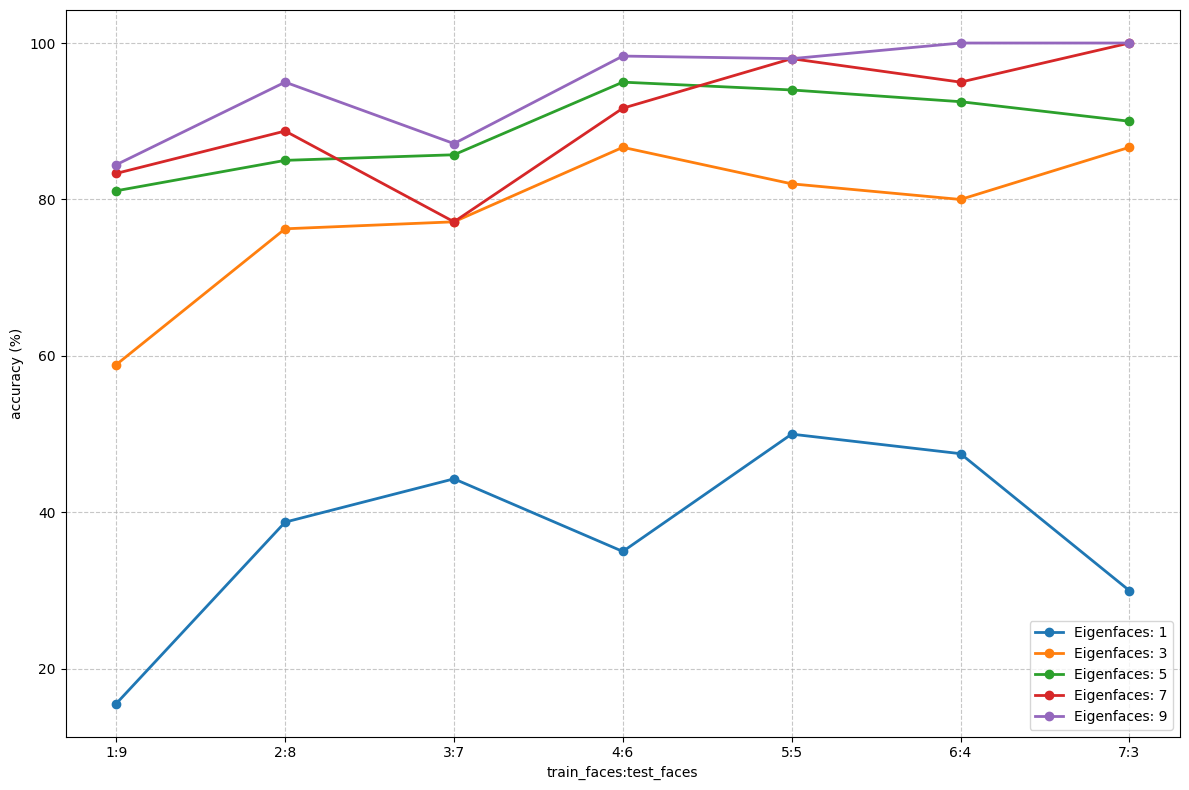

In [30]:
if __name__ == "__main__":
    results = main()